In [4]:
import numpy
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
import numpy as np
from config import *


## load data

In [5]:
from config import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# import all charging power predictions from directory
df_list = []
for file in os.listdir(result_directory + os.sep + "generatePredictions"):
    if file.endswith(".csv"):
        df_loaded = pd.read_csv(result_directory + os.sep + "generatePredictions" + os.sep + file, index_col = 0)
        # append one column to the dataframe
        df_list.append(df_loaded)

choose_column = "Power_original"

In [6]:
# get taz number of each charging station
taz_list = []
for file in os.listdir(result_directory + os.sep + "generatePredictions"):
    if file.endswith(".csv"):
        taz_list.append(file.split(".")[0])

In [7]:
def construct_numpy_array(df_list, choose_column):
    # construct numpy array
    array = np.zeros((len(df_list), len(df_list[0]))) # vector of shape (number of charging stations, number of time steps)
    timevector = df_list[0]["time"].to_numpy()
    for i in range(len(df_list)):
        array[i] = df_list[i][choose_column]
    return array, timevector

array, timevector = construct_numpy_array(df_list, "Power_original")

#### plot all predictions

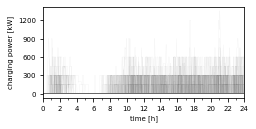

In [8]:
# plot all charging power predictions in one figure
plt.figure()
pltSettings()
# set the color of the lines
colors = plt.cm.jet(np.linspace(0,1,array.shape[0]))
for i in range(array.shape[0]):
    plt.plot(timevector/3600, array[i], color = 'dimgrey', alpha = 0.15, linewidth = 0.2)
plt.xlabel("time [h]")
plt.ylabel("charging power [kW]")
#plt.title("Charging power predictions")
ax = plt.gca()
ax.set_xlim([0,24])
ax.set_xticks(np.arange(0,25,2))
# set minor ticks inbetween
ax.set_xticks(np.arange(0,25,1), minor = True)
ax.set_yticks(np.arange(0, array.max(), 300))
fig = plt.gcf()
fig.set_size_inches(plotSizeX, 1.4* plotSizeY) #6.6, 2.7)

# save figure as pdf
fig.savefig(directory_figures + os.sep + "chargingPowerPredictions.pdf", bbox_inches='tight')

## k means dtw

In [96]:
timestep_in_min_new = 180
timestep_new = timestep_in_min_new*60 # 15 minutes
timevector_new = np.arange(1, 24*3600, timestep_new)
array_new = np.zeros((array.shape[0], len(timevector_new)))
for i in range(array.shape[0]):# loop through charging station
    j0 = 0
    for j in range(len(timevector_new)):# loop through time steps
        array_new[i,j] = sum(array[i, j0:j0+timestep_in_min_new]*timestep/3.6e3) # to calculate energy, multiply with timestep/3.6e3 in kWh
        j0 = j0 + timestep_in_min_new

In [101]:
import tqdm
n_clusters_list = np.arange(2, 20, 1)
dba_km_list = []
cluster_found_list=[]
silhouette_scores = []

X = TimeSeriesScalerMeanVariance().fit_transform(array_new)

for n_clusters in tqdm.tqdm(n_clusters_list):
    dba_km = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", verbose=False, n_jobs = -1)
    cluster_found = dba_km.fit_predict(X)
    cluster_found_list.append(cluster_found)
    silhouette_scores.append(dba_km.inertia_)
    dba_km_list.append(dba_km)

100%|██████████| 18/18 [00:06<00:00,  2.89it/s]


Text(0.5, 1.0, 'Silhouette scores')

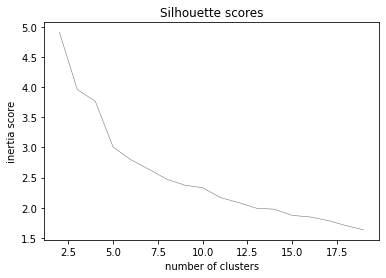

In [102]:
%matplotlib inline
plt.figure
plt.plot(n_clusters_list, silhouette_scores, color = 'dimgrey', linewidth = 0.5)
plt.xlabel("number of clusters")
plt.ylabel("inertia score")
plt.title("Silhouette scores")

In [105]:
# plot clusters
%matplotlib qt
n_clusters = 10
n_clusters_real = n_clusters-2
dba_km = dba_km_list[n_clusters_real]
cluster_found = cluster_found_list[n_clusters_real]
cluster_found = pd.Series(cluster_found, name = "cluster")

fig, ax = plt. subplots(1,n_clusters)
color_list = plt.cm.hsv(np.linspace(0,1,n_clusters))
df_array = pd.DataFrame(array_new)

for i in range(n_clusters):
    cluster = cluster_found[cluster_found == i]
    for j in cluster.index:
        ax[i].step(timevector_new/3600, array_new[j], color = color_list[i], alpha = 0.30, linewidth = 1)
    cluster = cluster_found[cluster_found == i]
    #ax[i].plot(timevector_new/3600, array_new[cluster.index].median(axis = 0), color = color_list[i], linewidth = 4)
    ax[i].plot(timevector_new/3600, dba_km.cluster_centers_[i].ravel(), color = color_list[i], linewidth = 4)
    # make color a bit darker

fig.set_size_inches(15,4)